In [3]:
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Project Pipeline

This notebook will focus on data preprocessing (**This part should be the same for all algorithms**) and implementation of kNN, Random Forest, Naive Bayes and XGboost.

(a) Import Dataset & Preview

(b) Data Preprocessing + feature engineering

(c) Feature selection

(d) kNN

(e) Random Forest

(f) Naive Bayes

(g) XGboost training

(h) Predict

(i) results

**EDA and Data visualization is on another jupyter notebook** (Please check eda.ipynb, add any additional methods that you find useful!)

# I. Import Dataset <a name="describe-dataset"></a>

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [5]:
train = train_df
test = test_df

In [6]:
train.head(5)

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [55]:
test.head(5)

Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

# Fast fact check on the dataset (columns, types, number of rows)

- Few important observations:
    - We have **878049** Observations of **9** variables (with duplicates which will be dropped).
    - We have a **'Dates'** column which contains the date and time of the occurence of the crime => String (Needs convertion).
    - We have **spatial coordinates** (Latitude and Longitude) of the exact place of the crime.
    - The Target column is **'Category'**, which is a Categorical Column (39 categories)
    - The **'DayOfWeek'** column is also Categorical (7 days) (needs convertion).
    - The **'PdDistrict'** column is also Categorical (10 districts) (needs convertion).
    - The **'Address'** column indicates whether the crime location was an intersection of two roads (how to make use of it?)
    - The **'Resolution'** column is irrelevant and will be droped.

## Check missing values

In [56]:
print (train.isnull().sum())
print (test.isnull().sum())

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64
Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64


## Check type of Data

In [57]:
print('Number of Categories: ', train.Category.nunique())
print('Number of PdDistricts: ', train.PdDistrict.nunique())
print('Number of DayOfWeeks: ', train.DayOfWeek.nunique())
print('_________________________________________________')
# Show some useful Information
train.info()

Number of Categories:  39
Number of PdDistricts:  10
Number of DayOfWeeks:  7
_________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


# II. Data Preprocessing & Feature Engineering 

 ## 1. Drop duplicates & the 'Resolution' column 

In [7]:
train = train.drop('Resolution', axis=1)

In [8]:
# drop all duplicte values 
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

# reset indices after dropping dups
train = train.reset_index()
test = test.reset_index()

## 2. Convert the 'Dates' Column

The 'Dates' column type is String. It will be easier to work with by parsing it to type of 'Datetime'.

In [9]:
train['Date'] = pd.to_datetime(train.Dates)
test['Date'] = pd.to_datetime(test.Dates)

train = train.drop('Dates', axis=1)
test = test.drop('Dates', axis=1)

In [10]:
train.sample(1)

index Category                         Descript DayOfWeek  PdDistrict  \
16001  16043  ASSAULT  AGGRAVATED ASSAULT WITH A KNIFE    Sunday  TENDERLOIN   

                           Address           X          Y                Date  
16001  100 Block of LEAVENWORTH ST -122.413893  37.782347 2015-02-22 07:05:00

### Feature Engineering (a): adding a feature to indicate whether the crime was commited by day (6:00-18:00)or by night

In [11]:
train['IsDay'] = 0
train.loc[ (train.Date.dt.hour > 6) & (train.Date.dt.hour < 18), 'IsDay' ] = 1
test['IsDay'] = 0
test.loc[ (test.Date.dt.hour > 6) & (test.Date.dt.hour < 18), 'IsDay' ] = 1

In [63]:
train.sample(3)

index        Category  \
488236  489702  OTHER OFFENSES   
131982  132371       VANDALISM   
263794  264523         ROBBERY   

                                               Descript DayOfWeek PdDistrict  \
488236              FAILURE TO REGISTER AS SEX OFFENDER    Monday   SOUTHERN   
131982        MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    Friday   NORTHERN   
263794  ROBBERY OF A COMMERCIAL ESTABLISHMENT W/ WEAPON    Monday   NORTHERN   

                         Address           X          Y                Date  \
488236        TURK ST / MASON ST -122.408954  37.783288 2008-06-23 21:06:00   
131982         POLK ST / POST ST -122.419930  37.786826 2013-08-09 22:51:00   
263794  2200 Block of VANNESS AV -122.423341  37.796245 2011-10-17 15:30:00   

        IsDay  
488236      0  
131982      0  
263794      1

### Feature Engineering (b): create 'DayOfWeekInt' columns

In [12]:
week_dic = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7,
}
train['DayOfWeek'] = train['DayOfWeek'].map(week_dic)
test['DayOfWeek'] = test['DayOfWeek'].map(week_dic)

In [13]:
train.DayOfWeek.unique()

array([3, 2, 1, 7, 6, 5, 4])

In [66]:
train.sample(1)

index Category                       Descript  DayOfWeek PdDistrict  \
62113  62299    FRAUD  FRAUDULENT CREDIT APPLICATION          1    TARAVAL   

                       Address           X          Y                Date  \
62113  0 Block of PINEHURST WY -122.465281  37.727508 2014-07-21 15:00:00   

       IsDay  
62113      1

### Feature Engineering (c): Create Minute, Hour, Day(relative), Month and Year(relative) Columns

In [14]:
train['Minute'] = train.Date.dt.minute
train['Hour'] = train.Date.dt.hour
train['Month'] = train.Date.dt.month
train['relative_Year'] = train.Date.dt.year - 2003 # Relative: actual day - the number of days since the first day in the data.
train['relative_Days'] = (train['Date'] - train['Date'].min()).apply(lambda x: x.days) # Relative: actual year - the number of days since the first day in the data.

test['Minute'] = test.Date.dt.minute
test['Hour'] = test.Date.dt.hour
test['Month'] = test.Date.dt.month
test['relative_Year'] = test.Date.dt.year - 2003 # Relative
test['relative_Days'] = (test['Date'] - train['Date'].min()).apply(lambda x: x.days) # Relative

In [68]:
train.sample(5)

index        Category                        Descript  DayOfWeek  \
861566  864147  MISSING PERSON                MISSING JUVENILE          5   
179026  179529         ROBBERY           ROBBERY, BODILY FORCE          4   
296187  297009           FRAUD    CREDIT CARD, THEFT BY USE OF          2   
660057  662069   DRUG/NARCOTIC  POSSESSION OF METH-AMPHETAMINE          1   
288926  289728   LARCENY/THEFT          GRAND THEFT PICKPOCKET          1   

       PdDistrict                  Address           X          Y  \
861566  INGLESIDE  300 Block of HARVARD ST -122.420053  37.725316   
179026   SOUTHERN   800 Block of MARKET ST -122.407634  37.784189   
296187       PARK  FELL ST / DIVISADERO ST -122.437613  37.774060   
660057   NORTHERN  FILLMORE ST / WALLER ST -122.430263  37.771173   
288926    CENTRAL     GEARY ST / POWELL ST -122.408231  37.787359   

                      Date  IsDay  Minute  Hour  Month  relative_Year  \
861566 2003-03-07 20:30:00      0      30    20      3              0   
179026 2012-12-27 11:05:00      1       5    11     12              9   
296187 2011-04-19 12:35:00      1      35    12      4              8   
660057 2005-12-26 12:49:00      1      49    12     12              2   
288926 2011-05-30 12:00:00      1       0    12      5              8   

        relative_Days  
861566             60  
179026           3643  
296187           3025  
660057           1085  
288926           3066

In [22]:
# save copied version for RF
in_train = train.copy()

### Deal with the cyclic characteristic of Minutes, Hour, Months and Days of Week:

(From other Kaggle Notebooks) Create ordinal representations for the features that present a kind of cyclicity (Month, Weekday, Hour, Minute). The reasoning behind this is that if we take the Hour as an example, the default representation implies that 23 and 00 (midnight) are 23 “units” away although in reality, they are 1 “unit” apart. A way to solve it is to imagine the hour in a real clock and take their projections on the axes passing from the center of the clock. This way the distance between 23 and 00 is the same as between 00 and 01. We can achieve this with functions like Hx = sin(2*π*H/23) & Hy = cos(2*π*H/23) for the hour and accordingly for the rest.

In [69]:
train['MinuteCos'] = np.cos((train['Minute']*2*np.pi)/60 )
train['HourCos'] = np.cos((train['Hour']*2*np.pi)/24 )
train['DayOfWeekCos'] = np.cos((train['DayOfWeek']*2*np.pi)/7 )
train['MonthCos'] = np.cos((train['Month']*2*np.pi)/12 )

test['MinuteCos'] = np.cos((test['Minute']*2*np.pi)/60 )
test['HourCos'] = np.cos((test['Hour']*2*np.pi)/24 )
test['DayOfWeekCos'] = np.cos((test['DayOfWeek']*2*np.pi)/7 )
test['MonthCos'] = np.cos((test['Month']*2*np.pi)/12 )

In [70]:
train.sample(5)

index        Category  \
654647  656634         ASSAULT   
638433  640371   LARCENY/THEFT   
231188  231833  SUSPICIOUS OCC   
738487  740717     WEAPON LAWS   
850597  853154  SUSPICIOUS OCC   

                                              Descript  DayOfWeek  PdDistrict  \
654647                          CHILD ABUSE (PHYSICAL)          1   INGLESIDE   
638433                    GRAND THEFT FROM LOCKED AUTO          7  TENDERLOIN   
231188                           SUSPICIOUS OCCURRENCE          4    SOUTHERN   
738487  EXHIBITING DEADLY WEAPON IN A THREATING MANNER          7     MISSION   
850597                           SUSPICIOUS OCCURRENCE          4     TARAVAL   

                       Address           X          Y                Date  \
654647  100 Block of AMAZON AV -122.439161  37.716842 2006-01-23 00:01:00   
638433     EDDY ST / LARKIN ST -122.417531  37.783311 2006-04-09 22:00:00   
231188  800 Block of BRYANT ST -122.403405  37.775421 2012-04-05 03:37:00   
738487     19TH ST / CASTRO ST -122.434854  37.759289 2004-10-31 23:00:00   
850597   2100 Block of 24TH AV -122.481305  37.747461 2003-05-01 13:40:00   

        IsDay  Minute  Hour  Month  relative_Year  relative_Days  MinuteCos  \
654647      0       1     0      1              3           1113   0.994522   
638433      0       0    22      4              3           1189   1.000000   
231188      0      37     3      4              9           3377  -0.743145   
738487      0       0    23     10              1            664   1.000000   
850597      1      40    13      5              0            115  -0.500000   

         HourCos  DayOfWeekCos  MonthCos  
654647  1.000000      0.623490  0.866025  
638433  0.866025      1.000000 -0.500000  
231188  0.707107     -0.900969 -0.500000  
738487  0.965926      1.000000  0.500000  
850597 -0.965926     -0.900969 -0.866025

## 3. Outliers

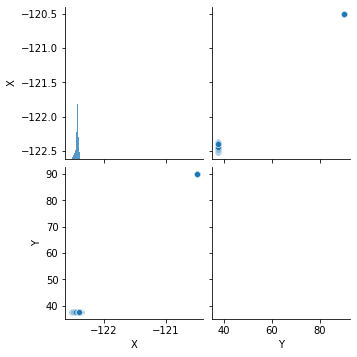

In [71]:
# plot pairwise relationship between X and Y
sns.pairplot(train[["X", "Y"]])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

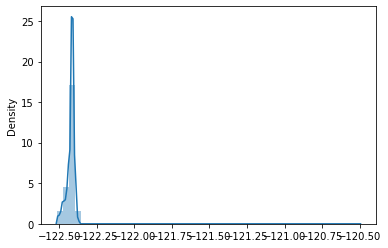

In [72]:
# get rid of an outlier
train_data = train[train["Y"] < 80]
sns.distplot(train[["X"]])

## 4. Dummy Encoding of 'PdDistrict': (1->10)

In [73]:
train = pd.get_dummies(train, columns=['PdDistrict'])
test  = pd.get_dummies(test,  columns=['PdDistrict'])
train.sample(2)

index       Category                     Descript  DayOfWeek  \
781188  783601  VEHICLE THEFT            STOLEN AUTOMOBILE          7   
835541  838068        ASSAULT  INFLICT INJURY ON COHABITEE          6   

                        Address           X          Y                Date  \
781188   FILBERT ST / TAYLOR ST -122.414305  37.800759 2004-04-04 18:00:00   
835541  200 Block of WINSTON DR -122.477894  37.727110 2003-07-12 16:00:00   

        IsDay  Minute  ...  PdDistrict_BAYVIEW  PdDistrict_CENTRAL  \
781188      0       0  ...                   0                   1   
835541      1       0  ...                   0                   0   

        PdDistrict_INGLESIDE  PdDistrict_MISSION  PdDistrict_NORTHERN  \
781188                     0                   0                    0   
835541                     0                   0                    0   

        PdDistrict_PARK  PdDistrict_RICHMOND  PdDistrict_SOUTHERN  \
781188                0                    0                    0   
835541                0                    0                    0   

        PdDistrict_TARAVAL  PdDistrict_TENDERLOIN  
781188                   0                      0  
835541                   1                      0  

[2 rows x 28 columns]

## 5. Label Encoding of 'Category':

In [74]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['CategoryInt'] = pd.Series(le.fit_transform(train.Category))

In [75]:
train.sample(1)['CategoryInt']

815100    20
Name: CategoryInt, dtype: int64

## 6. Feature engineering for 'Address'

Here i only added 'InIntersection' to indicate whether the crime happens in intersection.

**If anyone is interested in the implementation, More advanced convertion can be done, which can potentially increase accuracy and creativity of our project (ex. PCA)** Check out https://www.kaggle.com/sergeylebedev/initial-benchmark-need-tuning/code

In [76]:
train['InIntersection'] = 1
train.loc[train.Address.str.contains('Block'), 'InIntersection'] = 0

test['InIntersection'] = 1
test.loc[test.Address.str.contains('Block'), 'InIntersection'] = 0

In [77]:
train.sample(2)

index      Category                          Descript  DayOfWeek  \
581720  583481       ROBBERY  ROBBERY ON THE STREET WITH A GUN          4   
127411  127786  NON-CRIMINAL                    FOUND PROPERTY          2   

                          Address           X          Y                Date  \
581720  BRIGHTON AV / HOLLOWAY AV -122.455127  37.721848 2007-02-08 17:40:00   
127411      VALENCIA ST / 17TH ST -122.421734  37.763300 2013-09-03 13:30:00   

        IsDay  Minute  ...  PdDistrict_INGLESIDE  PdDistrict_MISSION  \
581720      1      40  ...                     0                   0   
127411      1      30  ...                     0                   1   

        PdDistrict_NORTHERN  PdDistrict_PARK  PdDistrict_RICHMOND  \
581720                    0                0                    0   
127411                    0                0                    0   

        PdDistrict_SOUTHERN  PdDistrict_TARAVAL  PdDistrict_TENDERLOIN  \
581720                    0                   1                      0   
127411                    0                   0                      0   

        CategoryInt  InIntersection  
581720           25               1  
127411           20               1  

[2 rows x 30 columns]

## 7. Standardizing Latitude and Longitude?


Not necessary for Decision trees and ensemble methods since they are not sensitive to the the variance in the data.

# III. Feature Selection

**Now let's get our dataset ready for training!**

In [78]:
train.columns

Index(['index', 'Category', 'Descript', 'DayOfWeek', 'Address', 'X', 'Y',
       'Date', 'IsDay', 'Minute', 'Hour', 'Month', 'relative_Year',
       'relative_Days', 'MinuteCos', 'HourCos', 'DayOfWeekCos', 'MonthCos',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'CategoryInt', 'InIntersection'],
      dtype='object')

In [79]:
test.columns

Index(['index', 'Id', 'DayOfWeek', 'Address', 'X', 'Y', 'Date', 'IsDay',
       'Minute', 'Hour', 'Month', 'relative_Year', 'relative_Days',
       'MinuteCos', 'HourCos', 'DayOfWeekCos', 'MonthCos',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'InIntersection'],
      dtype='object')

In [151]:
feature = ['X', 'Y','IsDay',
           'MinuteCos', 'HourCos', 'DayOfWeekCos', 'MonthCos',
           'relative_Year','relative_Days', 
           'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
           'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
           'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
           'PdDistrict_TENDERLOIN', 'InIntersection']
target = 'CategoryInt'

X = train[feature]
y = train[target]

test_ids = test_df['Id']
test_x = test[feature]

In [81]:
X.sample(1)

X          Y  IsDay  MinuteCos   HourCos  DayOfWeekCos  \
601217 -122.426452  37.798183      1   0.994522 -0.258819       0.62349   

        MonthCos  relative_Year  relative_Days  PdDistrict_BAYVIEW  \
601217       0.5              3           1384                   0   

        PdDistrict_CENTRAL  PdDistrict_INGLESIDE  PdDistrict_MISSION  \
601217                   0                     0                   0   

        PdDistrict_NORTHERN  PdDistrict_PARK  PdDistrict_RICHMOND  \
601217                    1                0                    0   

        PdDistrict_SOUTHERN  PdDistrict_TARAVAL  PdDistrict_TENDERLOIN  \
601217                    0                   0                      0   

        InIntersection  
601217               0

In [82]:
test_x.sample(1)

X          Y  IsDay  MinuteCos   HourCos  DayOfWeekCos  \
90547 -122.424171  37.727219      0        1.0  0.866025       0.62349   

           MonthCos  relative_Year  relative_Days  PdDistrict_BAYVIEW  \
90547  6.123234e-17             11           4072                   0   

       PdDistrict_CENTRAL  PdDistrict_INGLESIDE  PdDistrict_MISSION  \
90547                   0                     1                   0   

       PdDistrict_NORTHERN  PdDistrict_PARK  PdDistrict_RICHMOND  \
90547                    0                0                    0   

       PdDistrict_SOUTHERN  PdDistrict_TARAVAL  PdDistrict_TENDERLOIN  \
90547                    0                   0                      0   

       InIntersection  
90547               0


After the feature engineering described above, we ended up with 9-> 23 features. To identify if any of them increased the complexity of the model without adding significant gain to the model, we used the method of Permutation Importance.

The idea is that the importance of a feature can be measured by looking at how much the loss decreases when a feature is not available. To do that we can remove each feature from the dataset, re-train the estimator and check the impact. Doing this would require re-training an estimator for each feature, which can be computationally intensive. Instead, we can replace it with noise by shuffle values for a feature.

The implementation of the above technique showed that there is no need for any feature removal since all of them have a positive impact in the dataset.

In [83]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [84]:
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.3,
                                                  random_state = 123,
                                                  shuffle = True)

#model = LGBMClassifier(objective='multiclass', num_class=39).fit(train_X, train_y)
#
#perm = PermutationImportance(model).fit(val_X, val_y)
#eli5.show_weights(perm, feature_names=val_X.columns.tolist())

there is no need for any feature removal since all of them have a positive impact in the dataset.

# VI. Naive Bayes

# VII. XGBOOST Training (with Cross-Validation)

In [119]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

### Import XGBoost and create the DMatrices

In [120]:
import xgboost as xgb
train_xgb = xgb.DMatrix(X, label=y)
test_xgb  = xgb.DMatrix(test_x)

### Play with the parameters and do Cross-Validation

In [121]:
params = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 39,
}

In [122]:
CROSS_VAL = True
if CROSS_VAL:
    print('Doing Cross-validation ...')
    cv = xgb.cv(params, train_xgb, nfold=10, early_stopping_rounds=10, metrics='mlogloss', verbose_eval=True)
    cv

Doing Cross-validation ...
[22:57:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

KeyboardInterrupt: 

### Fit & Make the predictions

In [ ]:
SUBMIT = True
if SUBMIT:
    print('Fitting Model ...')
    m = xgb.train(params, train_xgb, 10)
    res = m.predict(test_xgb)
    cols = ['Id'] + le.classes_
    submission = pd.DataFrame(res, columns=le.classes_)
    submission.insert(0, 'Id', test_ids)
    submission.to_csv('submission.csv', index=False)
    print('Done Outputing !')
    print(submission.sample(3))
else:
    print('NOT SUBMITING')

### Results

Kaggle score(logloss): 2.46668